In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
import pandas as pd
import numpy as np
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

data = pd.read_csv('bump_loc_height_matrix.txt', delimiter=',', header=None).to_numpy()
data = data[:-1]


In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

In [3]:
def add_four_arrow(points, colors, ax, data=data):
    # Map the points to your x and y dimensions (considering your scale)
    mapped_points_x = points[:, 1]-1
    mapped_points_y = points[:, 0]-1
    point0 = np.array([mapped_points_x[0]/5, mapped_points_y[0]/5, data[mapped_points_y[0], mapped_points_x[0]]])
    point1 = np.array([mapped_points_x[1]/5, mapped_points_y[1]/5, data[mapped_points_y[1], mapped_points_x[1]]])
    point2 = np.array([mapped_points_x[2]/5, mapped_points_y[2]/5, data[mapped_points_y[2], mapped_points_x[2]]])
    point3 = np.array([mapped_points_x[3]/5, mapped_points_y[3]/5, data[mapped_points_y[3], mapped_points_x[3]]])
    arrow_prop_dict = dict(mutation_scale=20,
                           arrowstyle='-|>',
                           color=colors[2],
                           shrinkA=1,
                           shrinkB=1)
    arrow1 = Arrow3D([point0[0], point1[0]],
                     [point0[1], point1[1]],
                     [point0[2], point1[2]],
                     **arrow_prop_dict)
    arrow2 = Arrow3D([point1[0], point2[0]],
                     [point1[1], point2[1]],
                     [point1[2], point2[2]],
                     **arrow_prop_dict)
    arrow3 = Arrow3D([point2[0], point3[0]],
                     [point2[1], point3[1]],
                     [point2[2], point3[2]],
                     **arrow_prop_dict)
    arrow4 = Arrow3D([point3[0], point0[0]],
                     [point3[1], point0[1]],
                     [point3[2], point0[2]],
                     **arrow_prop_dict)
    ax.add_artist(arrow1)
    ax.add_artist(arrow2)
    ax.add_artist(arrow3)
    ax.add_artist(arrow4)
    data0 = data[mapped_points_y[0], mapped_points_x[0]]
    data1 = data[mapped_points_y[1], mapped_points_x[1]]
    data2 = data[mapped_points_y[2], mapped_points_x[2]]
    data3 = data[mapped_points_y[3], mapped_points_x[3]]

    for px, py in zip(mapped_points_x, mapped_points_y):
        z_value = data[int(py), int(px)]
        ax.plot(px/5, py/5,
                data[py, px],
                marker='o',
                color=colors[0],
                zorder=15)  # zorder=15 to prevent points covered by the surface
        ax.plot([px/5, px/5], [py/5, py/5], [13.2, z_value], c='gray', linestyle='--', linewidth=1)
    
    return np.array([data0, data1, data2, data3, data0])

def plot_sim(path_test, sim_data, colors, rank, coeff1, coeff2):
    sim_data_x = np.linspace(0, 1001, 5)
    sim_data_y = (sim_data-coeff1)*coeff2
    sim_data_z = np.polyfit(sim_data_x, sim_data_y, rank)
    sim_data_fit_x = np.linspace(0, 1000, 1000)
    sim_data_p = np.poly1d(sim_data_z)

    sig = pd.read_csv(path_test, delimiter=' ', header=None).to_numpy()
    sig = np.reshape(sig, (7, -1, 1000))
    sig_pack = sig[0]
    sig_avg = np.mean(np.transpose(sig, (0, 2, 1)), axis=2)

    fig = plt.figure(figsize=[2.5, 2.5])
    for arr in sig_pack:
        plt.plot(arr.T,
                color='silver',
                alpha=0.5,
                linewidth=1)
    plt.plot(sig_avg[0],
            color=colors[2],
            linewidth=3)
    plt.plot(sim_data_p(sim_data_fit_x),
            color=colors[1],
            linestyle='--',
            linewidth=2)
    plt.plot(sim_data_x, sim_data_y,
            marker='x',
            markeredgewidth=2,
            markersize=10,
            c=colors[0],
            linestyle='None')

    plt.xlabel('Time (ms)')
    plt.ylabel('log[fluence] (a. u.)')
    plt.ylim(-1, 1)

In [4]:
color1 = ['#003984', '#3297a3', '#00ffbe']
color2 = ['#7c0333', '#ae692f', '#dcba00']
color3 = ['#005500', '#259330', '#46d760']
color4 = ['#5f0074', '#a94895', '#f385b6']

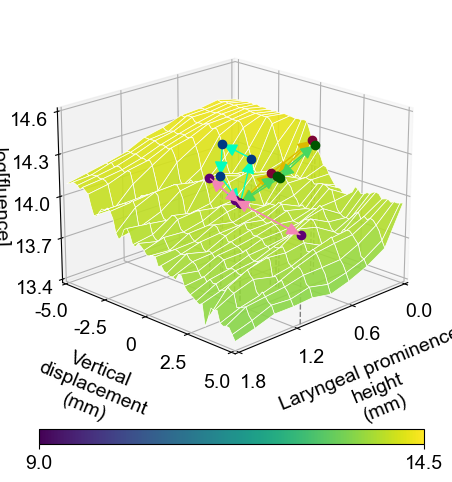

In [7]:
vmin = 9
vmax = 14.5

xx = np.arange(0, 2, 0.2)
yy = np.arange(0, 12, 0.2)
xx, yy = np.meshgrid(xx, yy)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(xx, yy, data,
                       vmin=vmin, vmax=vmax,
                       cmap=cm.viridis,
                       linewidth=0.5,
                       edgecolor='white',
                       alpha=0.9,
                       shade=True)
ax.view_init(elev=20, azim=45)
ax.set_xlim(0, 1.8)
ax.set_xticks(np.linspace(0, 1.8, 4))
ax.set_ylim(0, 11.8)
ax.set_yticks(np.linspace(0, 11.8, 5))
ax.set_yticklabels([-5.0, -2.5, 0, 2.5, 5.0])
ax.set_zlim(13.4, 14.6)
ax.set_zticks(np.linspace(13.4, 14.6, 5))
ax.set_xlabel('Laryngeal prominence\nheight\n(mm)', labelpad=20)
ax.set_ylabel('Vertical\ndisplacement\n(mm)', labelpad=20)
ax.set_zlabel('log[fluence]')

# Points to highlight
# original_points = np.array([1, 1], [20, 3], [50, 8], [60, 10])

# Range: [60, 10]
# First index: vertical disp. (-5, 5)
# Second index: adam's apple height (0, 1.8)

points = np.array([[29, 5], [20, 3], [16, 4], [22, 5],
                   [29, 5], [27, 3], [29, 1], [29, 3],
                   [29, 5], [29, 3], [30, 1], [30, 3],
                   [29, 5], [50, 5], [27, 5], [18, 5]])

p_swallow = np.array([0, 1, 2, 3])
p_throat_clear = p_swallow+4
p_dry_cough = p_swallow+8
p_walking = p_swallow+12
sim_swallow = add_four_arrow(points[p_swallow], color1, ax)
sim_throat_clear = add_four_arrow(points[p_throat_clear], color2, ax)
sim_dry_cough = add_four_arrow(points[p_dry_cough], color3, ax)
sim_walking = add_four_arrow(points[p_walking], color4, ax)

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

cax = fig.add_axes([0.13, 0.01, 0.77, 0.03])
cbr = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbr.set_ticks([vmin, vmax])

# plt.savefig('bump_loc_height_matrix.png', dpi=600,
#             bbox_inches='tight', pad_inches=0.4)
plt.show()

In [5]:
path_swallow = 'test_data/swallow.txt'
path_throat_clear = 'test_data/throat_clearing.txt'
path_dry_cough = 'test_data/dry_cough.txt'
path_walking = 'test_data/walking.txt'

In [14]:
path_test = path_swallow

sig = pd.read_csv(path_test, delimiter=' ', header=None).to_numpy()
sig = np.reshape(sig, (7, -1, 1000))
sig_pack = sig[0]
sig_avg = np.mean(np.transpose(sig, (0, 2, 1)), axis=2)

idx = np.around(np.linspace(0, len(sig_avg)-1, 5)).astype(int)
selected_sig_avg = sig_avg[:, idx]

selected_pvs = selected_sig_avg[0:4, :]
selected_ors = selected_sig_avg[4:, :]

selected_pvs

array([[-0.01578842, -0.01138708, -0.0091795 , -0.00697175, -0.00256867],
       [-0.37257517, -0.36888442, -0.36701442, -0.36513892, -0.36140383],
       [-0.35772083, -0.35524542, -0.35398408, -0.352712  , -0.350151  ],
       [-0.52150617, -0.52074258, -0.52028383, -0.51977675, -0.51863625]])

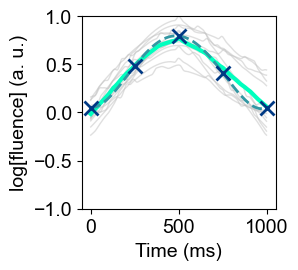

In [9]:
plot_sim(path_swallow, sim_swallow, color1, rank=4, coeff1=13.9, coeff2=2.5)
# plt.savefig('swallow_cycle.png', bbox_inches='tight', dpi=600)

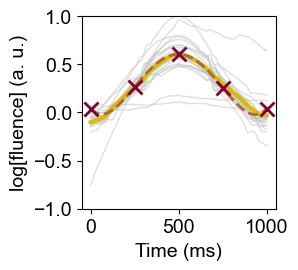

In [10]:
plot_sim(path_throat_clear, sim_throat_clear, color2, rank=4, coeff1=13.9, coeff2=2)
# plt.savefig('throat_clear_cycle.png', bbox_inches='tight', dpi=600)

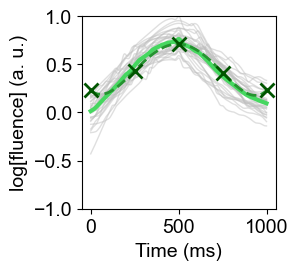

In [11]:
plot_sim(path_dry_cough, sim_dry_cough, color3, rank=4, coeff1=13.8, coeff2=1.9)
# plt.savefig('dry_cough_cycle.png', bbox_inches='tight', dpi=600)

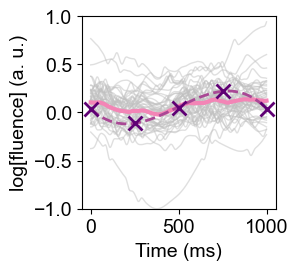

In [12]:
plot_sim(path_walking, sim_walking, color4, rank=3, coeff1=13.9, coeff2=1.8)
# plt.savefig('walking_cycle.png', bbox_inches='tight', dpi=600)

In [19]:
def plot_map(path, isLeft=False, isBottom=False):
    data = pd.read_csv(path, delimiter=',', header=None).to_numpy()
    data[data == -np.inf] = 0
    data = np.vstack([data, np.zeros(data.shape[0])])

    fig = plt.figure(figsize=[2, 2.5])

    plt.imshow(data, vmax=14.3, vmin=9)
    plt.gca()

    plt.xlim(0, 100)
    if isBottom:
        plt.xticks([10, 50, 90], [0, 4, 8])
        plt.xlabel('Depth (mm)')
    else:
        plt.xticks([])

    if isLeft:
        plt.yticks([0, 60, 120], [5.0, 0.0, -5.0])
        plt.ylabel('Vertical position (mm)')
    else:
        plt.yticks([])

    return fig

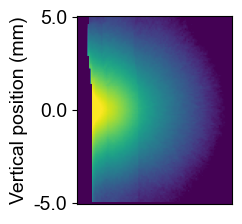

In [21]:
fig = plot_map('../maps/16-4.txt', isLeft=True)
plt.savefig('swallow_profile.png', dpi=600,
            bbox_inches='tight')

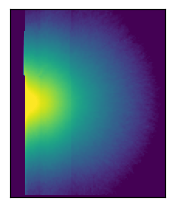

In [22]:
fig = plot_map('../maps/29-1.txt')
plt.savefig('throat_clear_profile.png', dpi=600,
            bbox_inches='tight')

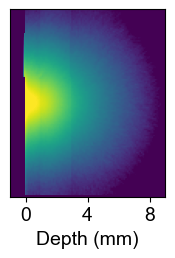

In [23]:
fig = plot_map('../maps/30-1.txt', isBottom=True)
plt.savefig('dry_cough_profile.png', dpi=600,
            bbox_inches='tight')

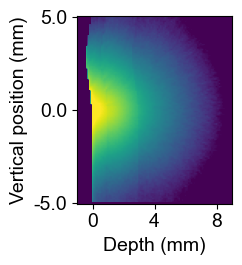

In [24]:
fig = plot_map('../maps/27-5.txt', isLeft=True, isBottom=True)
plt.savefig('walking_profile.png', dpi=600,
            bbox_inches='tight')

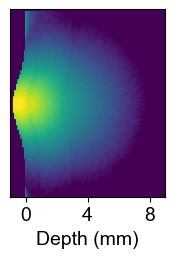

In [185]:
fig = plot_map('../maps/60-10.txt', isBottom=True)
plt.savefig('60-10.png', dpi=600,
            bbox_inches='tight')

In [261]:
def plot_scatter(path_1000, path_10000):
    data1000 = pd.read_csv(path_1000, delimiter=',', header=None).to_numpy()
    data10000 = pd.read_csv(path_10000, delimiter=',', header=None).to_numpy()
    xs1 = data1000[:, 0]
    ys1 = data1000[:, 1]
    zs1 = data1000[:, 2]
    xs2 = data10000[:, 0]
    ys2 = data10000[:, 1]
    zs2 = data10000[:, 2]

    fig = plt.figure(figsize=[3, 3])
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs1, ys1, zs1,
               marker='o',
               edgecolor=None,
               c='firebrick',
               s=0.1)
    ax.scatter(xs2, ys2, zs2,
               marker='o',
               edgecolor=None,
               c='silver',
               s=0.1)

    ax.set_xlabel('Y (mm)')
    ax.set_ylabel('X (mm)')
    ax.set_zlabel('D (mm)')

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)
    ax.set_zlim(0, 100)

    ax.set_xticks([0, 60, 120], [-1.8, 0, 1.8])
    ax.set_yticks([0, 60, 120], [-1.8, 0, 1.8])
    ax.set_zticks([10, 50, 90], [0, 4, 8])

    ax.view_init(elev=20, azim=25)

    return fig

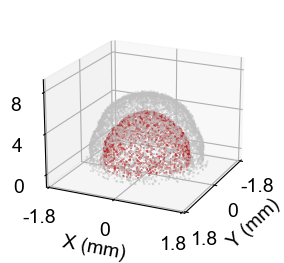

In [262]:
fig = plot_scatter('../damping_scatter/0-0-1000.txt', '../damping_scatter/0-0-10000.txt')

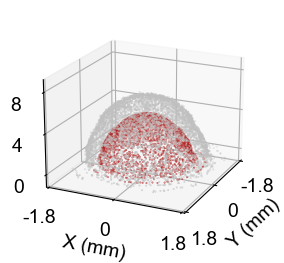

In [287]:
fig = plot_scatter('../damping_scatter/20-3-1000.txt', '../damping_scatter/20-3-10000.txt')

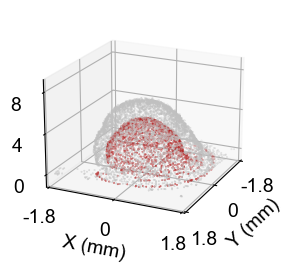

In [264]:
fig = plot_scatter('../damping_scatter/50-8-1000.txt', '../damping_scatter/50-8-10000.txt')

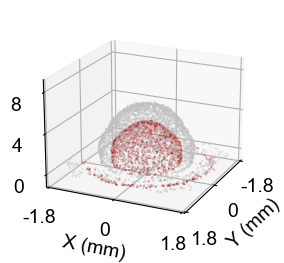

In [265]:
fig = plot_scatter('../damping_scatter/60-10-1000.txt', '../damping_scatter/60-10-10000.txt')